In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import spacy
import gensim
import time
import re
import string
import scipy
import collections

from nltk.corpus import stopwords
from stop_words import get_stop_words
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from spacy.lang.en.stop_words import STOP_WORDS
from gensim.summarization import keywords
from gensim.models import word2vec



%matplotlib inline

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', -1)

import warnings
warnings.filterwarnings('ignore')

c:\users\corey\appdata\local\programs\python\python37\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
path = os.path.join(os.getcwd(),'recipes')

# Show contents of recipe folder
recipes = os.listdir(path)


# Load in data
list_ = []
for recipe in recipes:
    df = pd.read_json(os.path.join(path,recipe), compression='xz', lines=True, encoding='Latin-1')
    list_.append(df)
    
# Get Column names and shape of each dataset
recipes_ = [x.split('.')[0].replace('-',' ').upper() for x in recipes]
data_cols = {}
for df,name in enumerate(recipes_):
    data_cols[name]=[list_[df].columns.tolist(),list_[df].shape]

In [3]:
# check columns from each dataset for merging
col_df = pd.DataFrame(data_cols)
print(col_df.head())

                                                                                                                                                                              ALLRECIPES RECIPES  \
0  [author, cook_time_minutes, description, error, footnotes, ingredients, instructions, photo_url, prep_time_minutes, rating_stars, review_count, time_scraped, title, total_time_minutes, url]   
1  (225602, 15)                                                                                                                                                                                    

                                                                                                                                                                                                               BBCCOUK RECIPES  \
0  [chef, chef_id, cooking_time_minutes, description, error, ingredients, instructions, instructions_detailed, photo_url, preparation_time_minutes, program, program_id, serves, time_scr

In [4]:
for x in range(4):
    print(recipes_[x])
    print(list_[x].columns.tolist())

ALLRECIPES RECIPES
['author', 'cook_time_minutes', 'description', 'error', 'footnotes', 'ingredients', 'instructions', 'photo_url', 'prep_time_minutes', 'rating_stars', 'review_count', 'time_scraped', 'title', 'total_time_minutes', 'url']
BBCCOUK RECIPES
['chef', 'chef_id', 'cooking_time_minutes', 'description', 'error', 'ingredients', 'instructions', 'instructions_detailed', 'photo_url', 'preparation_time_minutes', 'program', 'program_id', 'serves', 'time_scraped', 'title', 'total_time_minutes', 'url']
COOKSTR RECIPES
['chef', 'comment_count', 'contributors', 'cookbook', 'cookbook_publisher', 'cooking_method', 'copyright', 'cost', 'course', 'date_modified', 'description', 'dietary_considerations', 'difficulty', 'error', 'ingredients', 'ingredients_detailed', 'instructions', 'kid_friendly', 'make_ahead', 'makes', 'meal', 'occasion', 'photo_credit_name', 'photo_credit_site', 'photo_url', 'rating_count', 'rating_value', 'taste_and_texture', 'time_scraped', 'title', 'total_time', 'type_of

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225602 entries, 0 to 225601
Data columns (total 15 columns):
author                225602 non-null object
cook_time_minutes     225602 non-null int64
description           225602 non-null object
error                 225602 non-null bool
footnotes             225602 non-null object
ingredients           225602 non-null object
instructions          225602 non-null object
photo_url             225602 non-null object
prep_time_minutes     225602 non-null int64
rating_stars          225602 non-null float64
review_count          225602 non-null int64
time_scraped          225602 non-null int64
title                 225602 non-null object
total_time_minutes    225602 non-null int64
url                   225602 non-null object
dtypes: bool(1), float64(1), int64(5), object(8)
memory usage: 24.3+ MB
None
['Preheat oven to 400 degrees F (205 degrees C). Butter a 9x9x2 inch baking pan.', 'Melt 1 tablespoon butter in medium nonstick skillet over me

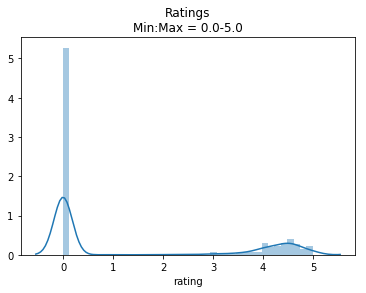

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91161 entries, 0 to 225601
Data columns (total 10 columns):
cook_time       91161 non-null int64
description     91161 non-null object
ingredients     91161 non-null object
instructions    91161 non-null object
prep_time       91161 non-null int64
rating          91161 non-null float64
review_count    91161 non-null int64
title           91161 non-null object
total_time      91161 non-null int64
url             91161 non-null object
dtypes: float64(1), int64(4), object(5)
memory usage: 7.7+ MB
None


In [5]:
# Allrecipes check
allrecipes = list_[0]
#print(allrecipes.head())
#print(allrecipes.columns.tolist())
#print(allrecipes.describe())
print(allrecipes.info())

# Drop error, author, time_scraped, photo_url
# Error Column is always False, Author is user_name for website, time_scraped and photo_url aren't important
#print(allrecipes.error.unique())
#print(allrecipes.author)

allrecipes = allrecipes.drop(['author', 'error', 'time_scraped', 'photo_url'], 1)

# change name of rating-stars to rating, and drop minutes from time variables
allrecipes.rename({'rating_stars':'rating', 
                   'cook_time_minutes':'cook_time',
                   'prep_time_minutes':'prep_time',
                   'total_time_minutes':'total_time'}, axis=1, inplace=True)
print(allrecipes.instructions[0])
print('-'*50)
print(allrecipes.ingredients[0])
print('-'*50)
print(allrecipes.description[0])
print('-'*50)
print(allrecipes.footnotes[0])
print('-'*50)

# combine the footnote column with the description column
allrecipes.footnotes = allrecipes.footnotes.apply(str)
allrecipes.description = allrecipes.description.str.cat(allrecipes.footnotes, sep=' ')
allrecipes.description = allrecipes.description.str.replace('[','').str.replace(']','')
print(allrecipes.description[4])

# Drop footnote
allrecipes = allrecipes.drop('footnotes',1)

# Check ratings
sns.distplot(allrecipes.rating)
plt.title("Ratings\nMin:Max = "+str(allrecipes.rating.min())+'-'+str(allrecipes.rating.max()))
plt.show()

#print(np.sort(allrecipes.rating.unique()))

# Drop duplicates
allrecipes.ingredients = allrecipes.ingredients.apply(', '.join)
allrecipes = allrecipes.drop_duplicates(subset='ingredients',keep='first')
# Check
print(allrecipes.info())
#print(allrecipes.head())

In [6]:
# BBC CO UK check
bbcrecipes = list_[1]

#print(bbcrecipes.head())
print(bbcrecipes.info())
#print(bbcrecipes.error.unique())

#print(bbcrecipes.instructions_detailed[0])
#print('-'*50)
#print(bbcrecipes.instructions[0])
#print('-'*50)
#print(bbcrecipes.ingredients[0])
#print('-'*50)
print(bbcrecipes.description[10])
print('-'*50)
print(bbcrecipes.program[10])

# Add program to descriptions
bbcrecipes.program = bbcrecipes.program.apply(str)
bbcrecipes.description = bbcrecipes.description.str.cat(bbcrecipes.program, sep=' ')

print(bbcrecipes.description[10])

# Drop error, chef, chef_id, instructions_detailed, photo_url, program, program_id, serves, time_scraped
bbcrecipes = bbcrecipes.drop(['error', 'chef', 'chef_id', 
                              'instructions_detailed', 'photo_url', 
                              'program', 'program_id', 'serves', 'time_scraped'], 1)

bbcrecipes.rename({'cooking_time_minutes':'cook_time',
                   'preparation_time_minutes':'prep_time',
                   'total_time_minutes':'total_time'}, axis=1, inplace=True)
# Check
print(bbcrecipes.info())
bbcrecipes.ingredients[0]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10599 entries, 0 to 10598
Data columns (total 17 columns):
chef                        10599 non-null object
chef_id                     10599 non-null object
cooking_time_minutes        10599 non-null int64
description                 10599 non-null object
error                       10599 non-null bool
ingredients                 10599 non-null object
instructions                10599 non-null object
instructions_detailed       10599 non-null object
photo_url                   2225 non-null object
preparation_time_minutes    10599 non-null int64
program                     9626 non-null object
program_id                  9626 non-null object
serves                      10599 non-null int64
time_scraped                10599 non-null int64
title                       10599 non-null object
total_time_minutes          10599 non-null int64
url                         10599 non-null object
dtypes: bool(1), int64(5), object(11)
memory usage:

['250g/8¾oz plain flour, plus extra for dusting',
 '8 tbsp olive oil',
 '2 tsp water',
 '1 tsp sea salt',
 '4 tbsp tomato purée',
 '60g/2¼oz shiitake mushrooms, sliced',
 '4 slices prosciutto',
 '100g/3½oz gorgonzola cheese',
 '1 free-range egg']

Cooking Methodpreserving
Christopher Idone
None
The Best of Christopher Idone
Stewart, Tabori & Chang
preserving
Inexpensive
None
egg-free, gluten-free, healthy, lactose-free, low calorie, low carb, low cholesterol, low-fat, peanut free, soy free, tree nut free, vegetarian
Easy
None
None
hot & spicy, savory, tangy, tart
Condiments, dip/spread
Cooking Methodpreserving Christopher Idone None The Best of Christopher Idone Stewart, Tabori & Chang preserving Inexpensive None egg-free, gluten-free, healthy, lactose-free, low calorie, low carb, low cholesterol, low-fat, peanut free, soy free, tree nut free, vegetarian Easy None None hot & spicy, savory, tangy, tart Condiments, dip/spread


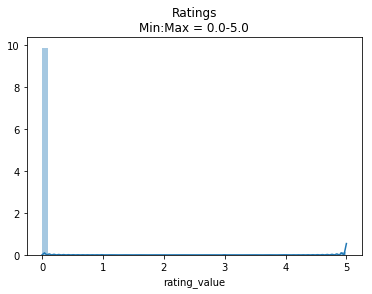

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7918 entries, 0 to 7917
Data columns (total 7 columns):
ingredients     7918 non-null object
instructions    7918 non-null object
rating          7918 non-null float64
title           7918 non-null object
total_time      7851 non-null object
url             7918 non-null object
description     7918 non-null object
dtypes: float64(1), object(6)
memory usage: 433.1+ KB
None
3624    Cooking Methodpreserving Christopher Idone None The Best of Christopher Idone Stewart, Tabori & Chang preserving Inexpensive None egg-free, gluten-free, healthy, lactose-free, low calorie, low carb, low cholesterol, low-fat, peanut free, soy free, tree nut free, vegetarian Easy None None hot & spicy, savory, tangy, tart Condiments, dip/spread
Name: description, dtype: object


['1 tablespoon softened butter',
 '2 tablespoons flour',
 '3 cups sifted cake flour (if you canâ\x80\x99t find cake flour, the same amount of all-purpose flour can be substituted)',
 '4 teaspoons double-acting baking powder',
 'Â½ teaspoon salt',
 '8 ounces (2 sticks) unsalted butter, at room temperature',
 '2 cups granulated sugar',
 '4 eggs, at room temperature',
 '1 cup milk, at room temperature',
 '1 to 1Â½ teaspoons vanilla extract',
 'Â¾ cup strained orange juice',
 '2 tablespoons lemon juice',
 'Â¾ cup granulated sugar',
 '1 tablespoon finely grated orange rind']

In [7]:
# COOKSTR check
cookstrecipes = list_[2]

#print(cookstrecipes.head())
#print(cookstrecipes.info())
#print(cookstrecipes[cookstrecipes.chef.isnull()]['contributors'])

# lets append the cookbook, publisher cooking_method, cost, course, chef, contributor, dietary_considerations, 
# difficulty, meal, occasion, taste/texture, and type of dish to the description

# Change description to og_description
cookstrecipes.rename(columns={'description':'description_og'}, inplace=True)
print(cookstrecipes.description_og[3624])
cols_to_append = ['chef', 'contributors', 'cookbook', 'cookbook_publisher', 
                  'cooking_method', 'cost', 'course', 'dietary_considerations',
                  'difficulty', 'meal', 'occasion', 'taste_and_texture', 'type_of_dish']
cookstrecipes['description'] = cookstrecipes['description_og'].str.cat(cookstrecipes[cols_to_append].astype(str), sep=' ', na_rep=' ')

for x in cols_to_append:
    print(cookstrecipes.loc[3624,x])
    
print(cookstrecipes.description[3624])

# Drop cols to append, comment_count, copyright, date_modified, error, ingredients_detailed, kid_friendly, make_ahead, makes,
# photo stuff, and time scraped
drop_cols = cols_to_append +['description_og','rating_count', 'comment_count', 'copyright',
                                  'date_modified','error','ingredients_detailed',
                                  'kid_friendly','make_ahead','makes',
                                  'photo_credit_name','photo_credit_site','photo_url','time_scraped']
# remove description from droplist
#drop_cols.pop(0)
#print(drop_cols)
cookstrecipes = cookstrecipes.drop(drop_cols, 1)

#print(cookstrecipes.total_time)

# Check ratings
cookstrecipes.rating_value.fillna(0,inplace=True)
sns.distplot(cookstrecipes.rating_value)
plt.title("Ratings\nMin:Max = "+str(cookstrecipes.rating_value.min())+'-'+str(cookstrecipes.rating_value.max()))
plt.show()

#print(cookstrecipes.rating_value.dropna())

# Rename
cookstrecipes.rename({'rating_value':'rating'}, axis=1, inplace=True)

# Check
print(cookstrecipes.info())
print(cookstrecipes[cookstrecipes.title=='Hot Hot Tomato Chutney']['description'])
cookstrecipes.ingredients[0]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34756 entries, 0 to 34755
Data columns (total 15 columns):
aggregateRating     34756 non-null float64
author              34756 non-null object
dateCrawled         34756 non-null int64
dek                 34756 non-null object
hed                 34756 non-null object
id                  34756 non-null object
ingredients         34656 non-null object
photoData           34756 non-null object
prepSteps           34756 non-null object
pubDate             34756 non-null object
reviewsCount        34756 non-null int64
tag                 34655 non-null object
type                34756 non-null object
url                 34756 non-null object
willMakeAgainPct    34756 non-null int64
dtypes: float64(1), int64(3), object(11)
memory usage: 4.0+ MB
None
How does fried chicken achieve No. 1 status? Brined, boneless thighs are responsible for incredible dark-meat flavor, and the dredge technique creates an insanely crunchy coating.
Pickle-Brined F

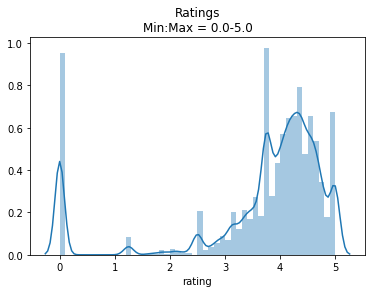

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34569 entries, 0 to 34755
Data columns (total 6 columns):
rating          34569 non-null float64
ingredients     34569 non-null object
instructions    34569 non-null object
review_count    34569 non-null int64
url             34569 non-null object
description     34569 non-null object
dtypes: float64(1), int64(1), object(4)
memory usage: 1.8+ MB
None


['1 tablespoons yellow mustard seeds',
 '1 tablespoons brown mustard seeds',
 '1 1/2 teaspoons coriander seeds',
 '1 cup apple cider vinegar',
 '2/3 cup kosher salt',
 '1/3 cup sugar',
 '1/4 cup chopped fresh dill',
 '8 skinless, boneless chicken thighs (about 3 pounds), halved, quartered if large',
 'Vegetable oil (for frying; about 10 cups)',
 '2 cups buttermilk',
 '2 cups all-purpose flour',
 'Kosher salt',
 'Honey, flaky sea salt (such as Maldon), toasted benne or sesame seeds, hot sauce (for serving)',
 'A deep-fry thermometer']

In [8]:
# epicurious check
epicuriousrecipes = list_[3]

#print(cookstrecipes.head())
print(epicuriousrecipes.info())
#print(epicuriousrecipes.author) drop
#print(epicuriousrecipes.id) drop

# Description = dek+hed
# Instructions =prepSteps
print(epicuriousrecipes.dek[0])
print(epicuriousrecipes.hed[0])
print(epicuriousrecipes.tag[0])

#epicuriousrecipes.tag = [[k,v] for k, v in epicuriousrecipes.tag.items()]

epicuriousrecipes['description'] = epicuriousrecipes.dek.str.cat([epicuriousrecipes.hed.map(str)], sep=' ')
                                                                  #epicuriousrecipes.tag.map(str)],

print(epicuriousrecipes.description[0])
epicuriousrecipes.rename({'prepSteps':'instructions', 'aggregateRating':'rating', 'reviewsCount':'review_count'}, axis=1, inplace=True)
#print(epicuriousrecipes.type.unique()) drop

# Change rating scale to 0-5
epicuriousrecipes.rating = epicuriousrecipes.rating*(5/4)

# Check ratings
sns.distplot(epicuriousrecipes.rating)
plt.title("Ratings\nMin:Max = "+str(epicuriousrecipes.rating.min())+'-'+str(epicuriousrecipes.rating.max()))
plt.show()


# 100 missing ingredient recipes
#print(epicuriousrecipes[epicuriousrecipes.ingredients.isnull()])

epicuriousrecipes = epicuriousrecipes.dropna(0)

drop_cols = ['author','dateCrawled', 'id', 'dek', 'hed', 'photoData', 'pubDate', 'type', 'willMakeAgainPct', 'tag']
epicuriousrecipes = epicuriousrecipes.drop(drop_cols,1)

print(epicuriousrecipes.info())
epicuriousrecipes.ingredients[0]

In [9]:
# check final dataframes
dfs = [allrecipes, bbcrecipes, cookstrecipes, epicuriousrecipes]
for df in dfs:
    print(df.columns,df.shape[1])
df_all = pd.concat(dfs,0, sort=True, ignore_index=True)

Index(['cook_time', 'description', 'ingredients', 'instructions', 'prep_time',
       'rating', 'review_count', 'title', 'total_time', 'url'],
      dtype='object') 10
Index(['cook_time', 'description', 'ingredients', 'instructions', 'prep_time',
       'title', 'total_time', 'url'],
      dtype='object') 8
Index(['ingredients', 'instructions', 'rating', 'title', 'total_time', 'url',
       'description'],
      dtype='object') 7
Index(['rating', 'ingredients', 'instructions', 'review_count', 'url',
       'description'],
      dtype='object') 6


In [10]:
#print(df_all.head())
print(df_all.shape)
print(df_all.info())
print(df_all.ingredients[0])

df_all.rating[df_all.rating>0].notnull().sum()

(144247, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144247 entries, 0 to 144246
Data columns (total 10 columns):
cook_time       101760 non-null float64
description     144247 non-null object
ingredients     144247 non-null object
instructions    144247 non-null object
prep_time       101760 non-null float64
rating          133648 non-null float64
review_count    125730 non-null float64
title           109678 non-null object
total_time      109611 non-null object
url             144247 non-null object
dtypes: float64(4), object(6)
memory usage: 11.0+ MB
None
1/2 cup unsalted butter, chilled and cubed, 1 cup chopped onion, 1 3/4 cups cornmeal, 1 1/4 cups all-purpose flour, 1/4 cup white sugar, 1 tablespoon baking powder, 1 1/2 teaspoons salt, 1/2 teaspoon baking soda, 1 1/2 cups buttermilk, 3 eggs, 1 1/2 cups shredded pepperjack cheese, 1 1/3 cups frozen corn kernels, thawed and drained, 2 ounces roasted marinated red bell peppers, drained and chopped, 1/2 cup chopped fresh b

104253

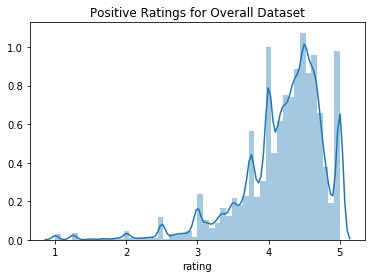

There are 104,253 non-zero ratings in the dataset


In [11]:
sns.distplot(df_all.rating[df_all.rating>0].dropna())
plt.title('Positive Ratings for Overall Dataset')
plt.show()

print("There are {:,d} non-zero ratings in the dataset".format(df_all.rating[df_all.rating>0].notnull().sum()))

[4 3 5 2 1 0]


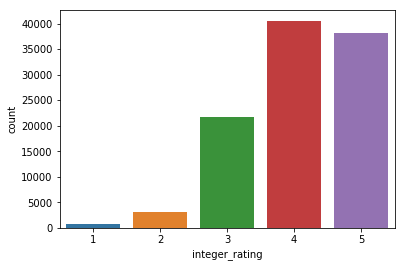

In [12]:
# create 5 categories for ratings
# 1-1.5 =< bin_1
# 1.5 < bin_2 =< 2.5
# 2.5 < bin_3 =< 3.5
# 3.5 < bin_4 < 4.5
# 4.5 < bin_5

df_all['integer_rating'] = pd.Series(0, index=df_all.index)
df_all.loc[(df_all.rating > 0)&(df_all.rating < 2),'integer_rating'] = 1
df_all.loc[(df_all.rating >= 2)&(df_all.rating < 3),'integer_rating'] = 2
df_all.loc[(df_all.rating >= 3)&(df_all.rating < 4),'integer_rating'] = 3
df_all.loc[(df_all.rating >= 4)&(df_all.rating < 4.5),'integer_rating'] = 4
df_all.loc[(df_all.rating >= 4.5),'integer_rating'] = 5

print(df_all.integer_rating.unique())
sns.countplot(df_all.integer_rating[df_all.integer_rating>0])
plt.show()

Want to build model to predict ratings from the 104K that we have to see if the missings can be imputed

In [13]:
print(df_all.shape)
print(df_all.dropna().shape)
print(df_all.title.isnull().sum())

print(df_all.columns)

(144247, 11)
(91161, 11)
34569
Index(['cook_time', 'description', 'ingredients', 'instructions', 'prep_time',
       'rating', 'review_count', 'title', 'total_time', 'url',
       'integer_rating'],
      dtype='object')


# Text Cleaning

In [14]:
recipe_df = df_all.dropna(1)

# Add title back
recipe_df['title'] = df_all.title
print(recipe_df.shape)
print(recipe_df.columns)
print(recipe_df.ingredients[0])
print('----')
print(recipe_df.instructions[0])
print('----')
# Turn description into list
for col in ['description', 'instructions']:
    recipe_df.loc[:,col] = recipe_df.loc[:,col].apply(lambda x: ' '+str(x))
print(recipe_df.description[0])
print('----')
# create "corpus" for each recipe
recipe_df.loc[:,'corpus'] = recipe_df['ingredients'].astype(str)+\
                            recipe_df['instructions'].astype(str)+\
                            recipe_df['description'].astype(str)
print(recipe_df.corpus[0])

(144247, 6)
Index(['description', 'ingredients', 'instructions', 'url', 'integer_rating',
       'title'],
      dtype='object')
1/2 cup unsalted butter, chilled and cubed, 1 cup chopped onion, 1 3/4 cups cornmeal, 1 1/4 cups all-purpose flour, 1/4 cup white sugar, 1 tablespoon baking powder, 1 1/2 teaspoons salt, 1/2 teaspoon baking soda, 1 1/2 cups buttermilk, 3 eggs, 1 1/2 cups shredded pepperjack cheese, 1 1/3 cups frozen corn kernels, thawed and drained, 2 ounces roasted marinated red bell peppers, drained and chopped, 1/2 cup chopped fresh basil
----
['Preheat oven to 400 degrees F (205 degrees C). Butter a 9x9x2 inch baking pan.', 'Melt 1 tablespoon butter in medium nonstick skillet over medium-low heat. Add onion and saute until tender, about 10 minutes. Cool.', 'Mix cornmeal with the flour, baking powder, sugar, salt, and baking soda in large bowl. Add 7 tablespoons butter and rub with fingertips until mixture resembles coarse meal.', 'Whisk buttermilk and eggs in medium bowl 

Let's first maunally clean the data.

In [15]:
# Wikipedia stopwords
wiki_stop = ['a','able','about','across','after','all','almost','also','am','among','an','and','any','are','as',
                     'at','be','because','been','but','by','can','cannot','could','dear','did','do',
                     'does','either','else','ever','every','for','from','get','got','had','has','have','he',
                     'her','hers','him','his','how','however','i','if','in','into','is','it','its','just','least',
                     'let','like','likely','may','me','might','most','must','my','neither','no','nor','not','of','off',
                     'often','on','only','or','other','our','own','rather','said','say','says','she','should','since',
                     'so','some','than','that','the','their','them','then','there','these','they','this','tis','to',
                     'too','twas','us','wants','was','we','were','what','when','where','which','while','who','whom','why',
                     'will','with','would','yet','you','your']
# NLTK Stop words
nltk_stop = list(stopwords.words("English"))

# Stop_words stop words
stop_words_py = get_stop_words('english')

# sklearn stop words
sk_stop = list(ENGLISH_STOP_WORDS)

# spaCy stop words
spacy_stop = list(STOP_WORDS)

all_stopwords = set(wiki_stop+nltk_stop+stop_words_py+sk_stop+spacy_stop)


def manual_text_cleaner(txt):
    
   # Remove all digits
    txt = re.sub(r'\d',' ',txt)
    
    # Remove punctuation.
    puncs = str.maketrans("","", string.punctuation)
    txt = txt.translate(puncs)
    
    # Remove stopwords
    txt = ' '.join([word for word in txt.split() if word not in (all_stopwords)])
    
    # make lowercase
    txt = txt.lower()
    
    # Get rid of extra whitespace.
    txt = ' '.join(txt.split())
    
    return txt

In [16]:
t0=time.time()
recipe_df.loc[:,'cleaned_text_1'] = recipe_df.corpus.apply(manual_text_cleaner)
print("Time to manually clean text: {:0.5f}s".format(time.time()-t0))

print(recipe_df.cleaned_text_1[0])

Time to manually clean text: 27.08101s
cup unsalted butter chilled cubed cup chopped onion cups cornmeal cups allpurpose flour cup white sugar tablespoon baking powder teaspoons salt teaspoon baking soda cups buttermilk eggs cups shredded pepperjack cheese cups frozen corn kernels thawed drained ounces roasted marinated red bell peppers drained chopped cup chopped fresh basil preheat oven degrees f degrees c butter x x inch baking pan melt tablespoon butter medium nonstick skillet mediumlow heat add onion saute tender minutes cool mix cornmeal flour baking powder sugar salt baking soda large bowl add tablespoons butter rub fingertips mixture resembles coarse meal whisk buttermilk eggs medium bowl blend add buttermilk mixture dry ingredients stir blended mix cheese corn red peppers basil onion transfer prepared pan bake cornbread golden tester inserted comes clean minutes cool minutes pan cut cornbread squares i started adding favorite things basic cornbread i came great


 We need to find the most and least frequenct words in the data to remove them since they offer little significance in the model.  To find the most/least common words overall we will need to combine all of the data into a list then perform a frequency count with counter.

In [17]:
# Make a giant string of all text
t0=time.time()

soup = recipe_df.cleaned_text_1.tolist()

# Tokenize and stem with nltk to count words
word_soup_tokens = []
for x in range(len(soup)):
    word_soup_tokens.append(word_tokenize(soup[x]))
    
# Flatten list
word_soup = [word for sublist in word_soup_tokens for word in sublist]

#t0=time.time()
# NLTK lemmatizer
#word_soup = []
#stemmer = SnowballStemmer("english")
#for token in word_soup_flat:
    #token = stemmer.stem(token)
    #word_soup.append(token)
#print("Time to stem with nltk: {:0.5f}s".format(time.time()-t0))
#print('----------------------')

print("Time to make soup: {:0.5f}s".format(time.time()-t0))
print(word_soup[:20])

Time to make soup: 114.46245s
['cup', 'unsalted', 'butter', 'chilled', 'cubed', 'cup', 'chopped', 'onion', 'cups', 'cornmeal', 'cups', 'allpurpose', 'flour', 'cup', 'white', 'sugar', 'tablespoon', 'baking', 'powder', 'teaspoons']


In [18]:
# Count most frequent words in word soup
t0=time.time()
counter = collections.Counter(word_soup)
print("Time to count soup: {:0.5f}s".format(time.time()-t0))
word_count = pd.Series(counter).sort_values(ascending=False)
#print(word_count[:20])
word_count_top = word_count[word_count>3000]
print(word_count_top[:25])
# Check histogram of word freq
#plt.hist((word_count[word_count>1]), bins=100)
#plt.title('Word Freq Hist')
#plt.show()

print(np.quantile(word_count, [.25, .5, .75, .9, .95, .99, .995]))

#print(word_count_top)
word_count_top.to_csv('C:\\Users\\Corey\\Desktop\\word_count_top.csv')

# From top word count we'll remove the top 1% of the non-food words
drop_list = pd.read_csv('drop_list.csv', names=['food','drop'])
print(drop_list.head(10))
drop_list = drop_list[drop_list['drop']==1]['food'].tolist()
print(drop_list[:10])

Time to count soup: 3.63774s
cup            340222
minutes        267230
heat           190867
salt           189968
teaspoon       183062
add            177314
oil            161599
pepper         157240
sugar          151505
tablespoons    144190
bowl           142691
large          139603
chopped        136870
butter         134551
cups           127815
stir           125038
water          124813
mixture        120852
cook           118237
oven           104913
sauce          102915
cheese         102391
baking         100469
place          97257 
fresh          96251 
dtype: int64
[1.00000e+00 1.00000e+00 5.00000e+00 3.40000e+01 1.54000e+02 2.98100e+03
 7.84325e+03]
          food  drop
0  cup          1   
1  minutes      1   
2  heat         1   
3  salt         0   
4  teaspoon     1   
5  add          1   
6  oil          0   
7  pepper       0   
8  sugar        0   
9  tablespoons  1   
['cup', 'minutes', 'heat', 'teaspoon', 'add', 'tablespoons', 'bowl', 'chopped', 'cups', 's

In [19]:
# remove most frequent non food words
def remove_most_freq(text):
    return ' '.join([word for word in text.split() if word not in drop_list])
    
t0=time.time()
recipe_df.loc[:,'cleaned_text_2'] = recipe_df.loc[:,'cleaned_text_1'].apply(remove_most_freq)
print('Time to remove most frequent non-food words: {:0.5f}s'.format(time.time()-t0))
print(recipe_df.cleaned_text_2[0])

Time to remove most frequent non-food words: 102.21066s
butter onion cornmeal flour sugar powder salt soda buttermilk eggs pepperjack cheese frozen corn kernels marinated bell peppers fresh basil butter butter onion tender cornmeal flour powder sugar salt soda large butter fingertips resembles buttermilk eggs buttermilk cheese corn peppers basil onion cornbread golden tester cornbread started favorite things basic cornbread came


# Parse Text, Lemmatize, and Build TFIDF Vectorizer for Finding Keywords

In [20]:
t0=time.time()
nlp = spacy.load('en', disable=['parser', 'tagger', 'ner'])

# Parse the dataset and tokenize - disable everything but the tokenizer
doc = recipe_df.cleaned_text_2.apply(nlp)
print("Time to parse text through spaCy: {:0.5f}s".format(time.time()-t0))
print(doc[0])

Time to parse text through spaCy: 397.52002s
butter onion cornmeal flour sugar powder salt soda buttermilk eggs pepperjack cheese frozen corn kernels marinated bell peppers fresh basil butter butter onion tender cornmeal flour powder sugar salt soda large butter fingertips resembles buttermilk eggs buttermilk cheese corn peppers basil onion cornbread golden tester cornbread started favorite things basic cornbread came


In [21]:
def get_lemmas(text):
    allwords = [token.lemma_ for token in text
                if token.is_alpha
                and not token.is_punct 
                and not token.is_stop 
                and not token.is_digit 
                and not token.like_num]
    return ' '.join(allwords)
t0=time.time()
doc_lemma = doc.apply(get_lemmas)
print("Time to get lemmas: {:0.5f}s".format(time.time()-t0))
print(doc_lemma[0])

Time to get lemmas: 19.35244s
butter onion cornmeal flour sugar powder salt soda buttermilk egg pepperjack cheese freeze corn kernel marinate bell pepper fresh basil butter butter onion tender cornmeal flour powder sugar salt soda large butter fingertip resemble buttermilk egg buttermilk cheese corn pepper basil onion cornbread golden tester cornbread start favorite thing basic cornbread come


In [22]:
#print(doc.head())
# Build TFIDF vectorizer to find keywords in each recipe
t0=time.time()
tfidf_vectorizer = TfidfVectorizer(strip_accents='unicode',
                                   min_df=2,
                                   stop_words='english',
                                   use_idf=True,
                                   norm='l2')#,
                                   #ngram_range=(1,2))
                                  

X = tfidf_vectorizer.fit_transform(doc_lemma)
print("Time to vectorize lemmatized recipes: {:0.5f}s".format(time.time()-t0))
print(X.shape)
vocab = tfidf_vectorizer.vocabulary_

Time to vectorize lemmatized recipes: 14.25837s
(144247, 32801)


## Get Keywords by TFIDF score

In [23]:
def top_n_idx_sparse(csr_matrix, n=10):
    '''Return index of top n values in each row of a sparse matrix'''
    
    top_n_idx = []
    
    # Get the indices and tfidf values for each recipe from the csr matrix  
    for left, right in zip(csr_matrix.indptr[:-1], csr_matrix.indptr[1:]):
        
        # Makes sure vector has enough non-zero elemets
        n_row_pick = min(n,right-left)
        
        # Append top n indices
        top_n_idx.append(csr_matrix.indices[left+np.argpartition(csr_matrix.data[left:right],-n_row_pick)[-n_row_pick:]])
    return top_n_idx

def get_keywords(index_list):
    '''Returns keys that match values in dictionary'''
    matching_keys = []
    dict_items = vocab.items()
    
    for item in dict_items:
        if item[1] in index_list:
            matching_keys.append(item[0])
            
    # Zip tfidf values to words
    return matching_keys

######### Allows for faster results because can now handle flattened list #############
def get_keywords1(dictionary, index_list, n=10):
    '''Returns keys that match values in dictionary'''
    matching_keys = []
    dict_items = dictionary.items()
    
    # loop through flat list of indices - faster that get_keywords because allows a flatlist to be searched 
    # instead of requiring a loop through each list of indices
    counter=0
    for x in index_list:
        for item in dict_items:
            if x == item[1]:
                matching_keys.append(item[0])
                counter+=1
                if counter%100==0:
                    print('running...{}'.format(counter))
                
                
    # Split the results into the n number of keywords
    i=0
    row=0
    new_list=[]
    while i<len(matching_keys):
        new_list.append(matching_keys[i:i+n])
        i+=n
        row+=1
        if row%5000 ==0:
            print("Running row {}".format(row))
    return new_list



def get_keywords2(csr_matrix):
    
    # Reverse order of vocabulary matrix
    index_word={i[1]:i[0] for i in vocab.items()}
    
    full_match = []
    for row in csr_matrix:
        # Append the word:tfidf value as a dictionary for each recipe (row)
        full_match.append(sorted([(index_word[word_col],tfidf_val) for (word_col,tfidf_val) in zip(row.indices,row.data)],
                                 key=lambda x: -x[1])[:10])
    
    return full_match

In [24]:
# Get indices for the keywords
#t0=time.time()
#keyword_indices = top_n_idx_sparse(X)

# Get list of keywords lists to add to recipe_df
#list_of_keywords = [l for subl in keyword_indices for l in subl]
    
# Add to recipe_df
#keyword_list = get_keywords1(vocab,list_of_keywords)

#print("Time to get keywords: {:0.5f}s".format(time.time()-t0))
#print(recipe_df.head())

In [25]:
t0=time.time()
tfidf_keywords = get_keywords2(X)
print('Time to get keywords: {:0.5f}s'.format(time.time()-t0))
print(tfidf_keywords[0][0][0])
print(len(tfidf_keywords))

# Add keywords to recipe_df
def extract_keywords(li):
    return [word[0] for word in li]

def extract_vectors(li):
    return np.asarray([word[1] for word in li])

recipe_df['tfidf_keywords_scores'] = tfidf_keywords
recipe_df['tfidf_keywords'] = recipe_df['tfidf_keywords_scores'].apply(extract_keywords)
recipe_df['keyword_vectors'] = recipe_df['tfidf_keywords_scores'].apply(extract_vectors)

#print(recipe_df[['tfidf_keywords_scores','tfidf_keywords']].head())
#print(recipe_df.keyword_vectors.head())

print(recipe_df.columns)

Time to get keywords: 12.64277s
cornbread
144247
Index(['description', 'ingredients', 'instructions', 'url', 'integer_rating',
       'title', 'corpus', 'cleaned_text_1', 'cleaned_text_2',
       'tfidf_keywords_scores', 'tfidf_keywords', 'keyword_vectors'],
      dtype='object')


## Add top 3 keywords to NaN titles

In [26]:
# For NaN titles add the top 3 keywords
missing_title_df = recipe_df[recipe_df['title'].isnull()]
#print(missing_title_df.head())
indices = recipe_df[recipe_df['title'].isnull()].index

# Get top 3 keywords
new_titles = []
for row in missing_title_df.tfidf_keywords:
    new_titles.append('Top 3 Keywords: '+str(', '.join(row[:3])))
#print(new_titles[:10])

# Zip indices to new titles
new_title_dict = dict(zip(indices,new_titles))

recipe_df.title = recipe_df.title.fillna(new_title_dict)
print(recipe_df.title.isnull().sum())

0


## Function to return recipes given ingredients

In [27]:
def brain_food(input_list):
    """Function that takes up to 10 ingredients and 
    returns recipes with keywords that are the most similar to the input"""
    t0=time.time()
    # Get idf score for each word entered.  If word is not in corpus throw error.
    idf_dict = dict(zip(tfidf_vectorizer.get_feature_names(),tfidf_vectorizer.idf_))
    
    input_vect = []
    for word in input_list:
        if word in idf_dict:
            input_vect.append(idf_dict[word])
            
        else:
            input_vect.append(0)
            print('{} not in corpus - no idf available'.format(word))
            
    # Make sure array has same number of elements as keywords
    num_keywords = len(recipe_df.keyword_vectors[0])
    ingredients = np.pad(input_vect, (0,(num_keywords-len(input_vect))), 'constant', constant_values=(0))
    
    # Get cosine similarity between input and rows
    sims = {}
    chunk = 1000
    chunk_df = recipe_df.sample(chunk)
    vectors = chunk_df.keyword_vectors.values
    index = chunk_df.index
    t = list(zip(index,vectors))
    counter = 0
    for label,array in t:
        if counter % 1000 == 0:
            print("running row", counter)
        padded_array = np.pad(array, (0,(num_keywords-len(array))), 'constant', constant_values=(0))
        sims[label] = cosine_similarity(ingredients.reshape(1, -1),padded_array.reshape(1, -1))[0]
        sims_df = pd.Series(sims).sort_values(ascending=False)
        counter+=1
        
    # Match index to recipe_df
    top=10
    top_ten = sims_df.index[:top]
    top_recipes = []
    for recipe in top_ten:
        top_recipes.append(recipe_df.loc[recipe,['title','description', 'ingredients', 'instructions', 
                                                 'url', 'integer_rating', 'tfidf_keywords_scores']])
    print("Done! Time for top {} recipes searched from {}:\n{:0.5f}s".format(top, chunk,(time.time()-t0)))
    return sims_df[:10], top_recipes
  
#brain_food(['bacon', 'eggs', 'cheese', 'bread', 'sausage', 'coffee'])

In [28]:
def brain_food_1(input_list):
    
    # Parse into spacy and get lemmas
    tokens = nlp(input_list)
    lemmas = get_lemmas(tokens)
    
    # Input vector needs to match matrix shape
    input_vec = np.zeros(X.shape[1])
    
    # One hot encode input vector
    lemmas = lemmas.split()
    for word in lemmas:
        input_vec[vocab[word]] += 1
 
    # Multiply tfidf matrix by input vector and sum
    tfidf_sparse = scipy.sparse.csc_matrix(X)
    similarity = tfidf_sparse * input_vec
    #similarity = np.dot(X,input_vec)
    
    # add to recipe_df
    recipe_df_alias = recipe_df.copy()
    recipe_df_alias['similarity'] = similarity
    recipe_df_alias = recipe_df_alias.sort_values(by='similarity', ascending=False)
    
    return recipe_df_alias[['title', 'cleaned_text_2', 'tfidf_keywords', 'url']].head(10)

In [29]:
test = brain_food_1('potatoes cheese bacon eggs')
print(test)

                                      title  \
13109  Cheesy Fried Potatoes                  
8858   Scrambled Potatoes                     
16026  Potato Skillet                         
11560  Cheese and Bacon Potato Rounds         
19739  Bacon Sunshine Skillet                 
25179  Potato Rounds                          
41442  Bacon Potato Omelet                    
24962  Breakfast Upside Down Cake             
32714  Campfire Skillet Breakfast             
85235  Laura's Breadless Fried Egg Sandwich   

                                                                                                                                                                                                                                                                                                                                                                                cleaned_text_2  \
13109  bacon butter onion potatoes salt pepper eggs cheddar cheese bacon large bacon crumble bac

# Word2Vec

In [30]:
#Build list of lists for word2vec from cleaned and lemmatized corpus
lemma_list = [x.split() for x in doc_lemma]

# Instantiate word2vec model
t0=time.time()
print('Builing vocabulary...')
w2v = word2vec.Word2Vec(lemma_list,        # build vocabulary on entire corpus - must be list of lists
                        workers=8,         # Number of threads in parallel
                        min_count=10,      # Minimum word count threshold.
                        window=12,         # Number of words around target word to consider.
                        sg=0,              # Use CBOW because our corpus is small.
                        sample=1e-5,       # Penalize frequent words.
                        size=200,          # Word vector length.
                        hs=1,              # Use hierarchical softmax.
                        iter=10)           # Epoch=10
print('Done!')
#print('Training Model...')

# Train word2vec
#w2v.train(recipe_df.cleaned_text_1, total_examples=recipe_df.shape[0], epochs=10)
print("Time {:.5f}s".format(time.time()-t0))

Builing vocabulary...
Done!
Time 51.87963s


In [42]:
# Add most similar word
test_list = ['cornbread', 'onion', 'corn', 'cheese', 'buttermilk', 'pepper']
for test in test_list:
    print(test)
    print(w2v.wv.most_similar(test,topn=5))
    print(w2v.wv.most_similar(test,topn=1)[0])
    print('-----')

cornbread
[('cornmeal', 0.49673062562942505), ('creamstyle', 0.4610818028450012), ('stuff', 0.4219648241996765), ('review', 0.4066615104675293), ('breadmuffin', 0.40255236625671387)]
('cornmeal', 0.49673062562942505)
-----
onion
[('pepper', 0.7174367904663086), ('garlic', 0.6916799545288086), ('clove', 0.5976157188415527), ('tender', 0.5846982002258301), ('bay', 0.5737773180007935)]
('pepper', 0.7174367904663086)
-----
corn
[('kernel', 0.8429156541824341), ('cob', 0.6756084561347961), ('ear', 0.6705958843231201), ('creamstyle', 0.6074792146682739), ('wholekernel', 0.5225975513458252)]
('kernel', 0.8429156541824341)
-----
cheese
[('cheddar', 0.6623671054840088), ('parmesan', 0.6506047248840332), ('mozzarella', 0.6247484683990479), ('bubbly', 0.5851935744285583), ('spinachmushroom', 0.5391191244125366)]
('cheddar', 0.6623671054840088)
-----
buttermilk
[('wellshaken', 0.6846441626548767), ('soda', 0.5867383480072021), ('selfrising', 0.5835298299789429), ('flour', 0.5521340370178223), ('co

In [32]:
def brain_food_2(input_list):
    '''Adds additional most similar words from word2vec model'''
    
    # Parse into spacy and get lemmas
    tokens = nlp(input_list)
    lemmas = get_lemmas(tokens)
    
    # Input vector needs to match matrix shape
    input_vec = np.zeros(X.shape[1])
    
    # Add most similar word to input vector to increase diversity
    lemmas = lemmas.split()
    similar_to_input = []
    for word in lemmas:
        similar_to_input.append(w2v.wv.most_similar(word,topn=1)[0][0])
        
    diverse_lemmas = lemmas+similar_to_input
    
    print("Your keyword ingredients are:\n",diverse_lemmas)
    # One hot encode input vector
    for word in diverse_lemmas:
        input_vec[vocab[word]] += 1
 
    # Multiply tfidf matrix by input vector and sum
    tfidf_sparse = scipy.sparse.csc_matrix(X)
    similarity = tfidf_sparse * input_vec
    #similarity = np.dot(X,input_vec)
    
    # add to recipe_df
    recipe_df_alias = recipe_df.copy()
    recipe_df_alias['similarity'] = similarity
    recipe_df_alias = recipe_df_alias.sort_values(by='similarity', ascending=False)
    
    return recipe_df_alias[['title', 'cleaned_text_2', 'tfidf_keywords','url']].head(10)

In [33]:
test1 = brain_food_2('potatoes cheese bacon eggs')
print(test1)

Your keyword ingredients are:
 ['potato', 'cheese', 'bacon', 'egg', 'russet', 'cheddar', 'thickcut', 'yolk']
                                       title  \
73810   Easy Loaded Baked Potato Casserole     
13109   Cheesy Fried Potatoes                  
8858    Scrambled Potatoes                     
85235   Laura's Breadless Fried Egg Sandwich   
26543   Teena's Bacon and Cheddar Potatoes     
25179   Potato Rounds                          
88823   Twice-Baked Potato Casserole           
24899   Bacon Cheddar Deviled Eggs             
136753  Top 3 Keywords: bacon, potato, onion   
71663   Spicy Bacon Deviled Eggs               

                                                                                                                                                                                                                                                                                                                                                                          

## Build matrix on tfidf keywords

In [34]:
keyword_set = set([word for sublist in recipe_df.tfidf_keywords.tolist() for word in sublist])
print(len(keyword_set))

t0=time.time()
count_vec = CountVectorizer(strip_accents='unicode',
                                   min_df=2,                # keep words that occur more than 2 times
                                   stop_words='english',    # English stop words
                                   vocabulary=keyword_set,  # Build on keywords from each recipe
                                   binary=True)             # use binary flag to indicate whether or not word is present
                            
tfidf_keyword_matrix = count_vec.fit_transform(doc_lemma)
print("Time to build tfidf keyword matrix: {:0.5f}s".format(time.time()-t0))
print(tfidf_keyword_matrix.shape)

tfidf_keyword_vocab = count_vec.vocabulary_

32008
Time to build tfidf keyword matrix: 13.49815s
(144247, 32008)


In [35]:
def brain_food_3(input_list):
    ''' Adds additional similar words
        Keyword matrix built on tfidf keywords'''
    
    # Parse into spacy and get lemmas
    tokens = nlp(input_list)
    lemmas = get_lemmas(tokens)
    
    # Input vector needs to match matrix shape
    input_vec = np.zeros(tfidf_keyword_matrix.shape[1])
    
    # Add most similar word to input vector to increase diversity
    lemmas = lemmas.split()
    similar_to_input = []
    for word in lemmas:
        similar_to_input.append(w2v.wv.most_similar(word,topn=1)[0][0])
        
    diverse_lemmas = lemmas+similar_to_input
    
    print("Your keyword ingredients are:\n",diverse_lemmas)
    
    # One hot encode input vector
    for word in diverse_lemmas:
        input_vec[tfidf_keyword_vocab[word]] += 1
 
    # Multiply tfidf matrix by input vector and sum
    tfidf_keyword_sparse = scipy.sparse.csc_matrix(tfidf_keyword_matrix)
    similarity = tfidf_keyword_sparse * input_vec
    
    
    # add to recipe_df
    recipe_df_alias = recipe_df.copy()
    recipe_df_alias['similarity'] = similarity
    recipe_df_alias = recipe_df_alias.sort_values(by='similarity', ascending=False)
    
    return recipe_df_alias[['title', 'cleaned_text_2', 'tfidf_keywords','url']].head(10)

In [36]:
test1 = brain_food_3('butter onion cornmeal flour sugar powder salt soda buttermilk')
print(test1)

Your keyword ingredients are:
 ['butter', 'onion', 'cornmeal', 'flour', 'sugar', 'powder', 'salt', 'soda', 'buttermilk', 'flour', 'pepper', 'stoneground', 'butter', 'vanilla', 'flour', 'large', 'sift', 'wellshaken']
                                                     title  \
102232  Basic Down-Home Hush Puppies                         
0       Basil, Roasted Peppers and Monterey Jack Cornbread   
131071  Top 3 Keywords: cornmeal, cheddar, buttermilk        
116012  Top 3 Keywords: cornmeal, peppercorn, cracker        
116019  Top 3 Keywords: buttermilk, cake, blackberry         
137338  Top 3 Keywords: griddle, cornmeal, corn              
139087  Top 3 Keywords: corn, buttermilk, basil              
71671   Jalapeno Green Onion Ale Corn Bread                  
121730  Top 3 Keywords: cake, berry, sugar                   
119797  Top 3 Keywords: cake, glaze, buttermilk              

                                                                                                     

119797  /recipes/food/views/caramel-cake-241217                                                      


## Keyword from gensim

In [37]:
#print(keywords(recipe_df.cleaned_text_2[0]).split('\n'))
#t0=time.time()
#recipe_df['gensim_keyword'] = recipe_df.cleaned_text_2.apply(keywords).apply(lambda x: x.split('\n'))
#print("Time for gensim keywords: {0:.5f}s".format(time.time()-t0))

In [38]:
#gensim_set = set([word for sublist in recipe_df.gensim_keyword.tolist() for word in sublist])
#print(gensim_set[:100])

#t0=time.time()
#count_vec = CountVectorizer(strip_accents='unicode',
                                   #min_df=2,                # keep words that occur more than 2 times
                                   #stop_words='english',    # English stop words
                                   ##vocabulary=gensim_set,   # Build on gensim keywords from each recipe
                                   #binary=True)             # use binary flag to indicate whether or not word is present
                            
#gensim_matrix = count_vec.fit_transform(doc_lemma)
#print("Time to build tfidf keyword matrix: {:0.5f}s".format(time.time()-t0))
#print(gensim_matrix.shape)

#gensim_vocab = count_vec.vocabulary_

## Full Tfidf Matrix, cosine similarity for similar word

In [47]:
def brain_food_4(input_list):
    ''' Adds additional similar word tfidf score to input vector
        Built on full tfidf matrix'''
    
    # Parse into spacy and get lemmas
    tokens = nlp(input_list)
    lemmas = get_lemmas(tokens)
    
    # Input vector needs to match matrix shape
    input_vec = np.zeros(X.shape[1])
    
    # Add most similar word to input vector to increase diversity
    lemmas = lemmas.split()
    similar_to_input = []
    similar_words = []
    for word in lemmas:
        similar_to_input.append(w2v.wv.most_similar(word,topn=1)[0])
        similar_words.append(w2v.wv.most_similar(word,topn=1)[0][0])
    
    diverse_lemmas = lemmas+similar_words
    
    print("Your keyword ingredients are:\n",diverse_lemmas)
    
    # One hot encode input vector
    for word in lemmas:
        input_vec[vocab[word]] += 1
        
    # Add cosine similarities for similar word score
    for word,score in similar_to_input:
        input_vec[vocab[word]] += score
 
    # Multiply tfidf matrix by input vector and sum
    tfidf_sparse = scipy.sparse.csc_matrix(X)
    similarity = tfidf_sparse * input_vec
    
    
    # add to recipe_df
    recipe_df_alias = recipe_df.copy()
    recipe_df_alias['similarity'] = similarity
    recipe_df_alias = recipe_df_alias.sort_values(by='similarity', ascending=False)
    
    return recipe_df_alias[['title', 'cleaned_text_2', 'tfidf_keywords','url']].head(10)

In [48]:
brain_food_4('potato cheese bacon eggs')

Your keyword ingredients are:
 ['potato', 'cheese', 'bacon', 'egg', 'russet', 'cheddar', 'thickcut', 'yolk']
russet 0.7867745757102966
cheddar 0.6623671054840088
thickcut 0.6615359783172607
yolk 0.7264999151229858


,title,cleaned_text_2,tfidf_keywords,url
13109,Cheesy Fried Potatoes,bacon butter onion potatoes salt pepper eggs cheddar cheese bacon large bacon crumble bacon butter onion potatoes potatoes golden crack eggs potatoes salt pepper cheese bacon eggs cheese family loves fried potatoes leftovers dinner,"[bacon, potato, cheese, egg, crack, love, crumble, fry, onion, butter]",http://allrecipes.com/Recipe/20511/
8858,Scrambled Potatoes,bacon potatoes cheddar cheese eggs large bacon crispy bacon potatoes bacon drippings tender large eggs salt pepper eggs potatoes cheese bacon potatoes cheese fantastic christmas breakfast brunch,"[bacon, potato, cheese, egg, fantastic, drippings, brunch, christmas, crispy, breakfast]",http://allrecipes.com/Recipe/15622/
73810,Easy Loaded Baked Potato Casserole,yukon gold potatoes bacon cheddar cheese milk sour cream salt pepper onions cheddar cheese potatoes large water tender potatoes bacon large bacon crumble cheddar cheese milk sour cream salt pepper potatoes potato masher creamy potato bacon onions cheddar cheese cheese easy potato casserole bacon cheddar onions,"[potato, bacon, cheddar, cheese, sour, onion, yukon, masher, gold, milk]",http://allrecipes.com/Recipe/231699/
85235,Laura's Breadless Fried Egg Sandwich,bacon eggs salt pepper cheddar cheese bacon large crumble crack eggs salt pepper egg whites flip eggs bacon cheddar cheese egg doneness cheese egg crispy bacon cheddar cheese stuffed fried eggs so delicious,"[bacon, egg, cheddar, cheese, doneness, flip, crack, crispy, crumble, fry]",http://allrecipes.com/Recipe/245539/
25179,Potato Rounds,large potatoes bacon cheddar cheese potatoes large water tender pierced bacon large crisp crumble potatoes crumbles bacon cheddar cheese cheese potato bacon cheese appetizer lot potato skins,"[potato, bacon, crumble, cheese, cheddar, pierce, skin, lot, appetizer, large]",http://allrecipes.com/Recipe/70699/
11560,Cheese and Bacon Potato Rounds,potatoes butter bacon cheddar cheese onions potato butter cookie potatoes bacon cheese onion cheese potatoes cheese bacona sour cream desire,"[potato, cheese, bacon, desire, onion, butter, cookie, cheddar, sour, cream]",http://allrecipes.com/Recipe/18344/
16026,Potato Skillet,bacon potatoes garlic salt salt pepper eggs cheddar cheese bacon large bacon crumble bacon potatoes bacon garlic salt seasoned salt pepper potatoes potatoes tender bacon eggs potatoes cheese son loves doesnt care breakfast,"[bacon, potato, son, salt, care, love, crumble, cheese, breakfast, egg]",http://allrecipes.com/Recipe/24156/
26543,Teena's Bacon and Cheddar Potatoes,large russet potatoes scrubbed butter bacon onion cottage cheese onion cheddar cheese salt pepper butter cheddar cheese paprika potatoes large water tender potatoes butter bacon large bacon drippings bacon towellined crumble bacon onion onion turned scrape onion potatoes bacon cottage cheese onion cheddar cheese salt pepper potato dot butter cheddar cheese paprika cheese bubbling yummy potato goes chicken beef usual suspects thanksgiving,"[bacon, potato, cheese, cheddar, onion, cottage, suspect, paprika, butter, usual]",http://allrecipes.com/Recipe/76462/
136753,"Top 3 Keywords: bacon, potato, onion",bacon onion large eggs russet potatoes cheddar pepper bacon onion large bacon crisp onion eggs bacon spreading bacon potato pie,"[bacon, potato, onion, russet, spread, egg, cheddar, pie, crisp, large]",/recipes/food/views/bacon-and-potato-pie-1590
88823,Twice-Baked Potato Casserole,butter russet potatoes salt sour cream cream cheese cheddar cheese real bacon chives optional butter potatoes large water tender potatoes salt sour cream cream cheese cheddar cheese bacon potato cheddar cheese cheese chives easy delicious always favorite busy things buy readytomash potatoes frozen section potatoes,"[potato, cheese, cheddar, cream, chive, bacon, sour, busy, russet, buy]",http://allrecipes.com/Recipe/256027/


# Predict Recipe Rating
### Integer Rating


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression, LogisticRegression

# A rating of 0 is a missing
sns.countplot(np.where(recipe_df.integer_rating>0,1,0))
plt.title("Rated vs Missing Recipes")
plt.show()

# Train on 80% of rated recipes - use tfidf vectors for features
rated_index = recipe_df[recipe_df.integer_rating>0].index
y = recipe_df.integer_rating.iloc[rated_index]
tfidf_features = X[X.indices[rated_index]]
#print(tfidf_features.shape)

# Split training and test
xtrain, xtest, ytrain, ytest = train_test_split(tfidf_features, y, test_size=0.2, random_state=34)
#for x in [xtrain, xtest, ytrain, ytest]:
    #print(x.shape)

In [ ]:
def rate(model, label):
    clf = model
    clf.fit(xtrain, ytrain)
    
    # Predict on test
    clf_pred = clf.predict(xtest)
    
    # Score test
    print(label)
    print("Accuracy:",clf.score(xtest,ytest))
    print(confusion_matrix(ytest,clf_pred))
    print(classification_report(ytest, clf_pred))
    print('_'*75)
    return

In [ ]:
# Naive Bayes
rate(MultinomialNB(), 'Multinomial')
rate(ComplementNB(), 'Complement')

In [ ]:
# KNN
rate(KNeighborsClassifier(),'KNN')

In [ ]:
# Random Forest
rfc = RandomForestClassifier(n_estimators=10,
                             max_depth=5,
                             random_state=34)
rate(rfc, "RFC")